In [10]:
# From Diego's script fakequake2homogenous.py

import numpy as np
from mudpy import view, forward
import os
from pyproj import Geod
from shutil import copy, move

In [2]:
# path = '/Users/sydneydybing/SW4/strain/experiments/'
path = '/Users/sydneydybing/SW4/strain/experiments/hold_rise_change_slip/'
files_list = os.listdir(path + 'hetero_rupts/')
# print(files_list)

rupts_list = []
for file in files_list:
    if file == '.DS_Store' or file == 'logfiles' or file == 'srfs':
        continue
    rupts_list.append(file)

print(rupts_list)
rupt = rupts_list[1]

['usgs_plane_fine_force_hypo.000001.rupt', 'usgs_plane_fine_force_hypo.000000.rupt']


In [3]:
desired_slips = [0.05, 0.1, 0.25, 0.5, 1, 2, 3, 4, 5, 10]

print(rupt)
rupture = np.genfromtxt(path + 'hetero_rupts/' + rupt)
log = open(path + 'hetero_rupts/logfiles/' + rupt.split('.rupt')[0] + '.log', 'r')

while True:
    line = log.readline()
    if 'Hypocenter (lon,lat,z[km])' in line:
        orig_hypo = line.split(':')[1].split(',')
        orig_hypo_lon = float(orig_hypo[0].split(' (')[1])
        orig_hypo_lat = float(orig_hypo[1])
        orig_hypo_depth = float(orig_hypo[2].split(')')[0])
    if 'Average Rupture Velocity (km/s):' in line:
        v_rupt = float(line.split(': ')[1])
    if 'Actual magnitude' in line:
        Mw = float(line.split()[-1])
    elif line == '':
        break
log.close()

# Calculate earthquake rise time using relation in Melgar and Hayes, 2017 for the original M7.1
apref = -5.323
bpref = 0.293
M0 = 10**(1.5*Mw + 9.05)
logS = apref + bpref * np.log10(M0)
MH_rise_time = round(10**logS,1)
rise_time = round(MH_rise_time,1)

print('Log file rupture velocity: ' + str(round(v_rupt,2)) + ' km/s')
print('Log file Mw: ' + str(Mw))
print('Log file hypocenter: (' + str(orig_hypo_lon) + ', ' + str(orig_hypo_lat) + '), ' + str(orig_hypo_depth) + ' km deep')
print('MH2017 rise time for this Mw: ' + str(MH_rise_time) + ' s')
print('Rise time to use for this rupture model: ' + str(rise_time) + ' s')

usgs_plane_fine_force_hypo.000000.rupt
Log file rupture velocity: 2.86 km/s
Log file Mw: 7.1
Log file hypocenter: (-117.620771, 35.779107), 11.6 km deep
MH2017 rise time for this Mw: 2.8 s
Rise time to use for this rupture model: 2.8 s


Desired slip on each subfault: 0.05 m
Equivalent Mw for homogeneous slip for full fault area: 6.4548



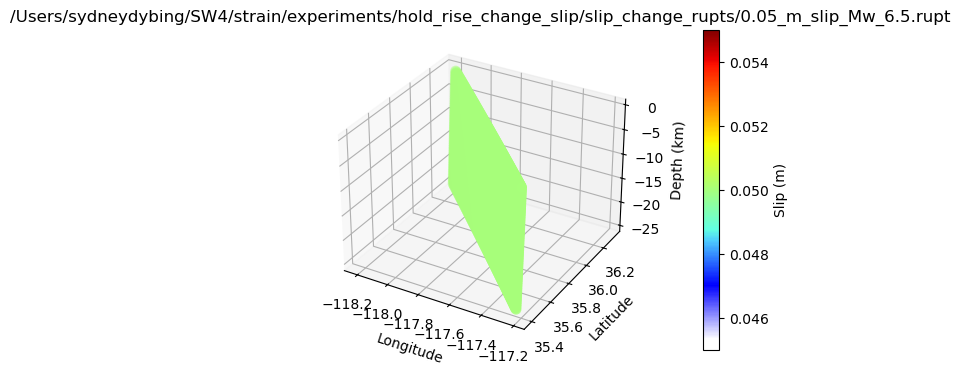

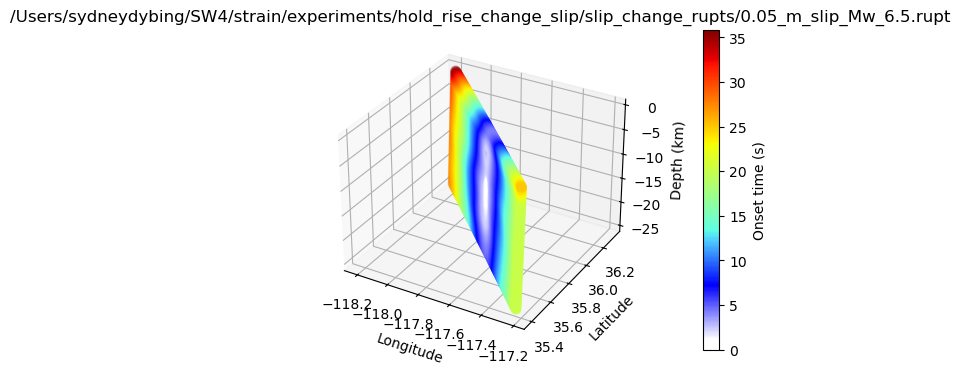

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 0.1 m
Equivalent Mw for homogeneous slip for full fault area: 6.6555



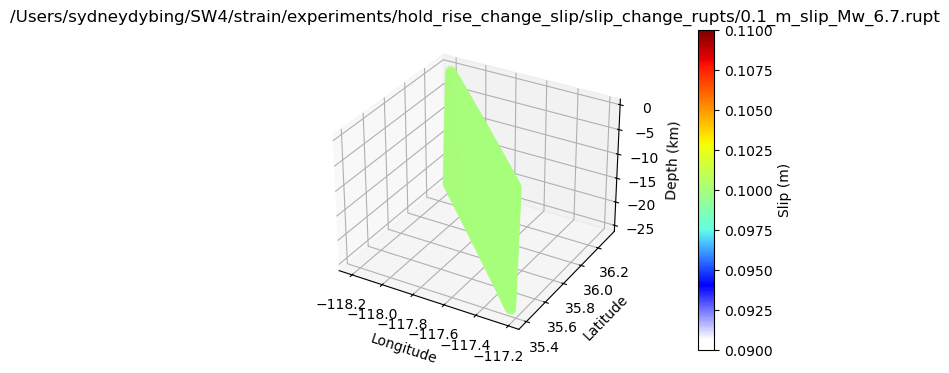

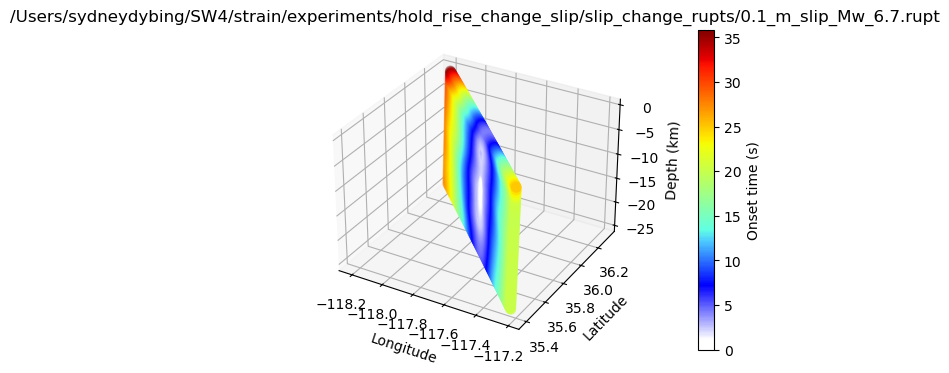

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 0.25 m
Equivalent Mw for homogeneous slip for full fault area: 6.9208



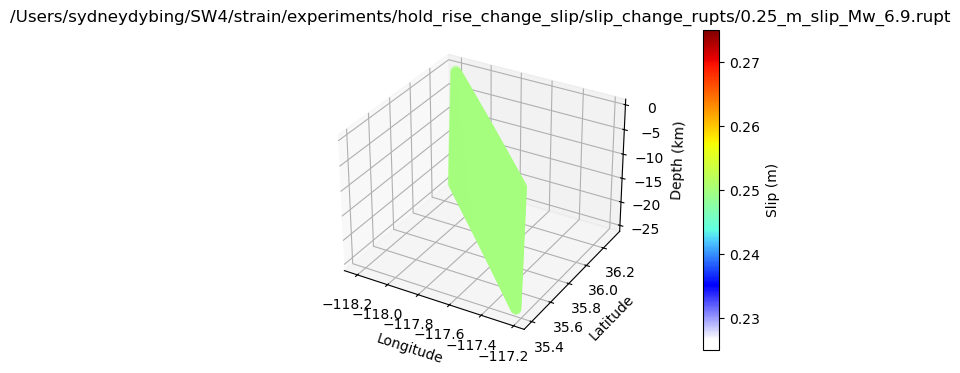

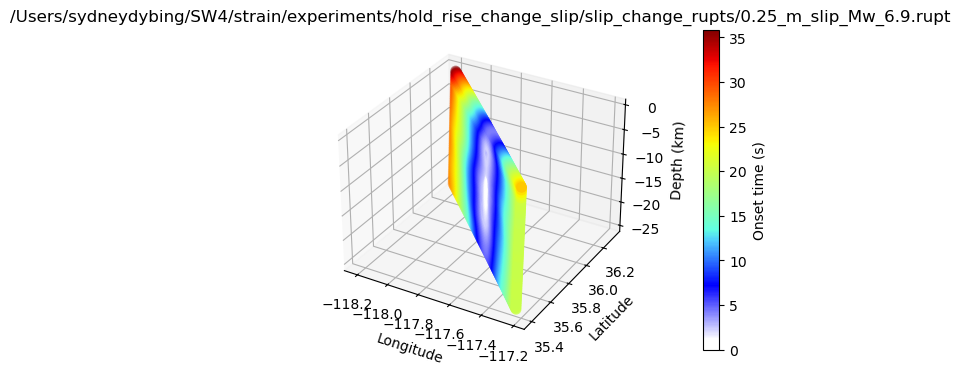

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 0.5 m
Equivalent Mw for homogeneous slip for full fault area: 7.1215



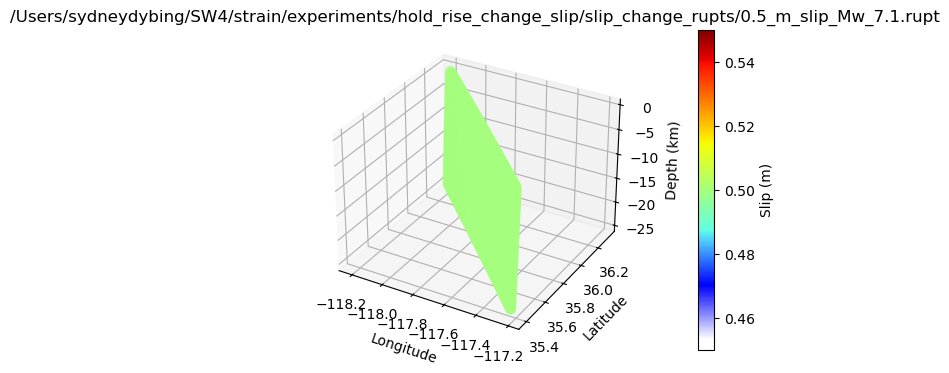

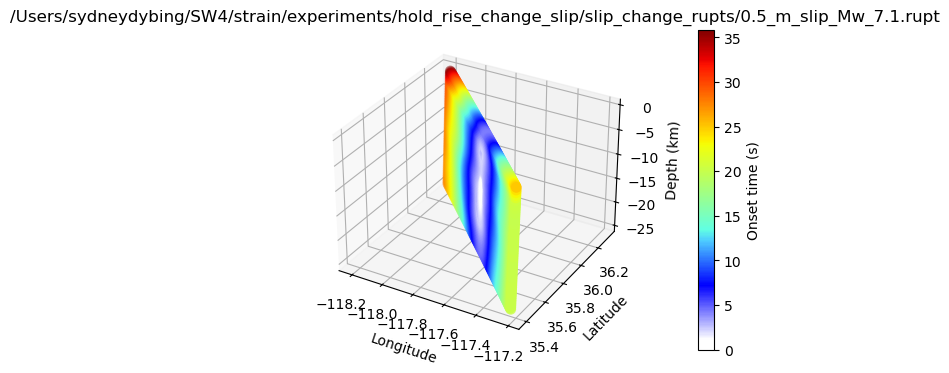

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 1 m
Equivalent Mw for homogeneous slip for full fault area: 7.3222



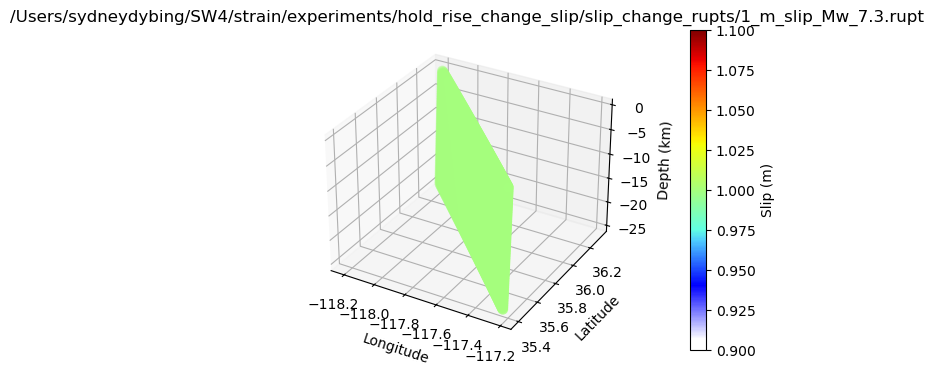

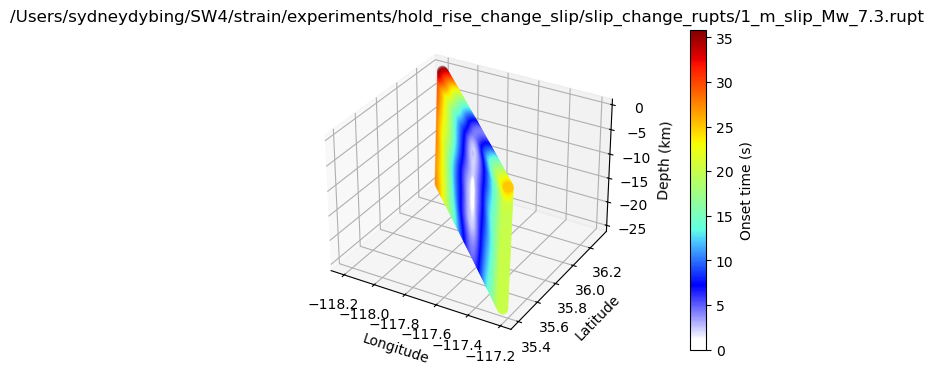

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 2 m
Equivalent Mw for homogeneous slip for full fault area: 7.5229



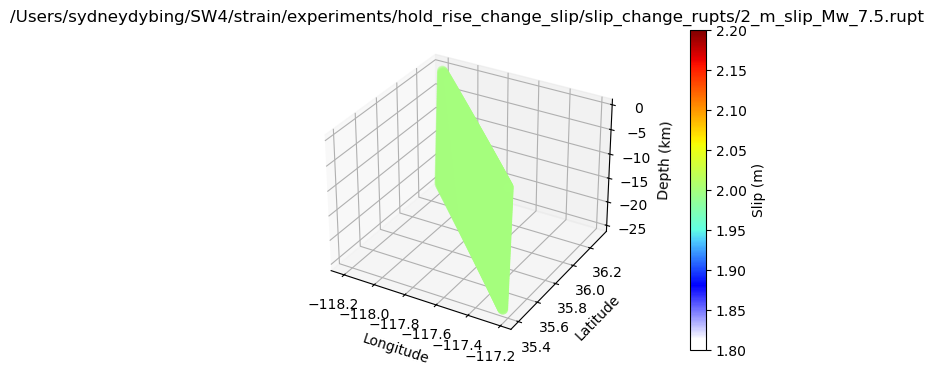

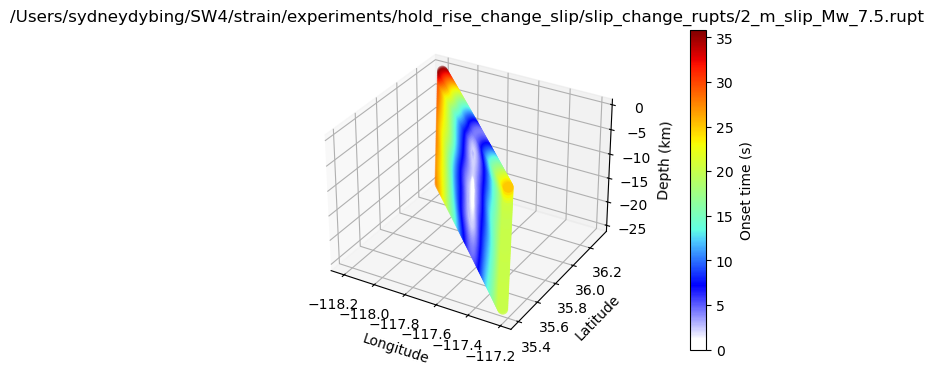

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 3 m
Equivalent Mw for homogeneous slip for full fault area: 7.6403



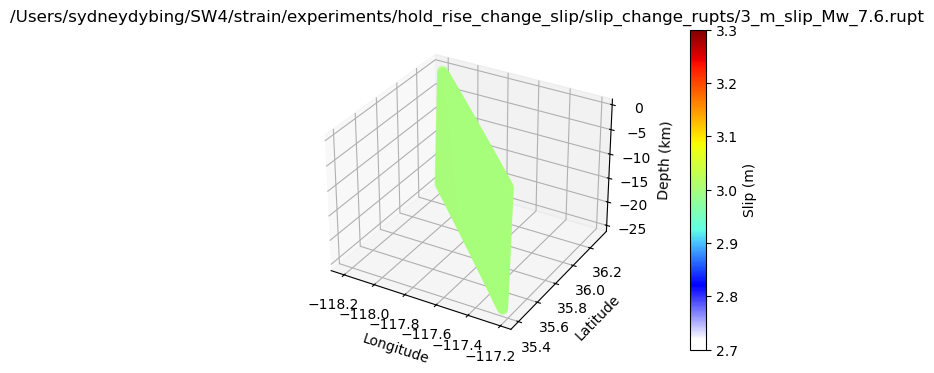

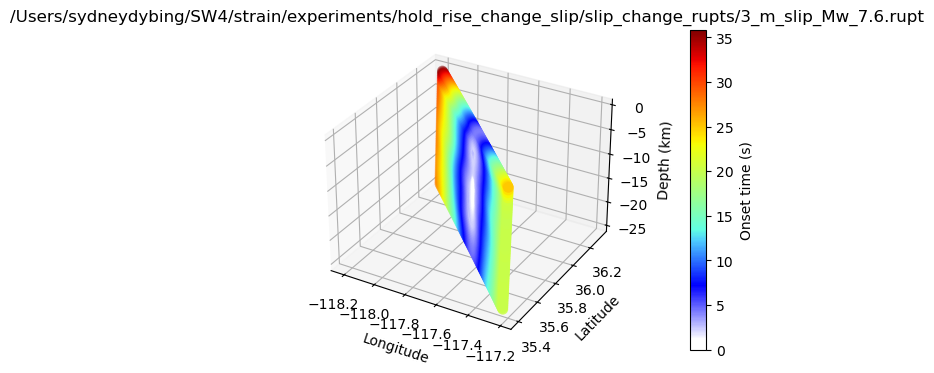

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 4 m
Equivalent Mw for homogeneous slip for full fault area: 7.7236



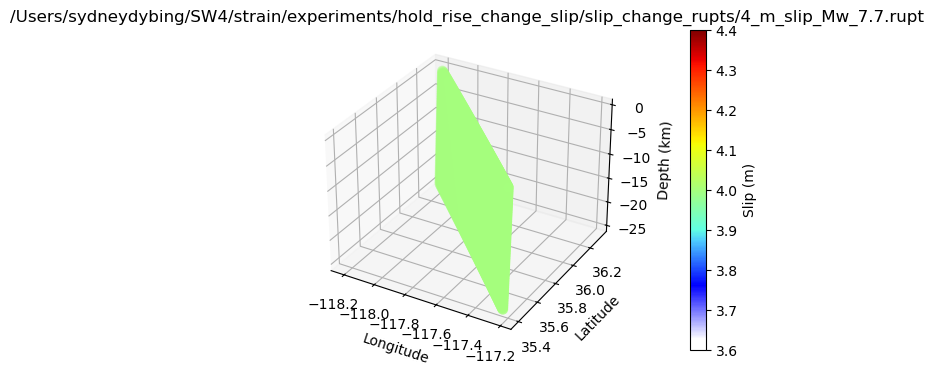

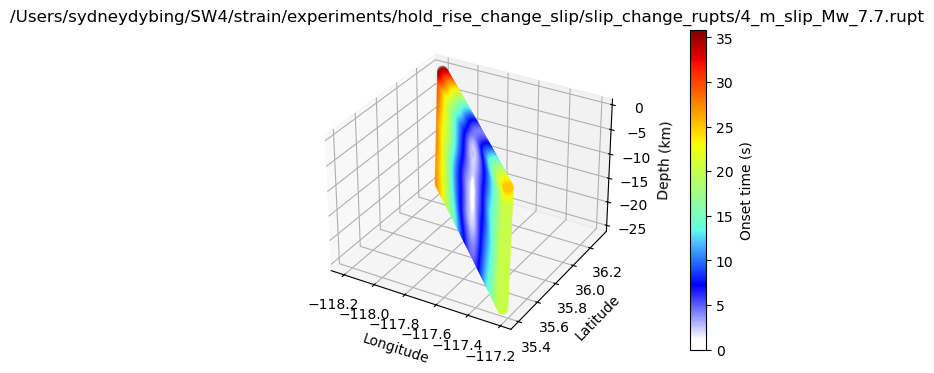

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 5 m
Equivalent Mw for homogeneous slip for full fault area: 7.7882



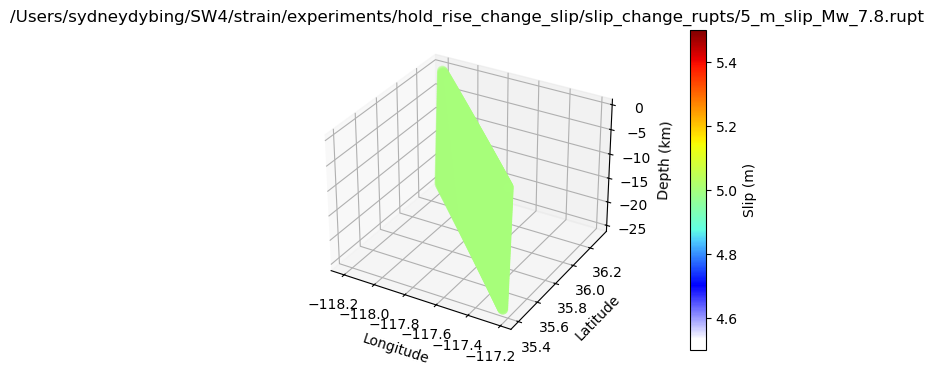

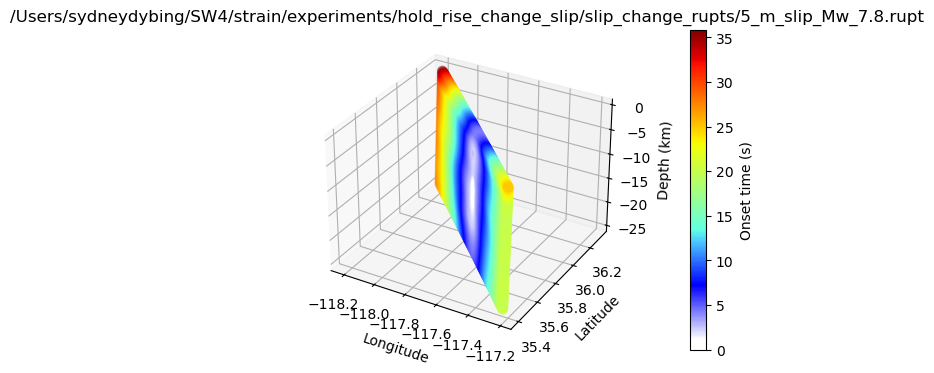

SRF saved!
-------------------------------------------------------------
Desired slip on each subfault: 10 m
Equivalent Mw for homogeneous slip for full fault area: 7.9889



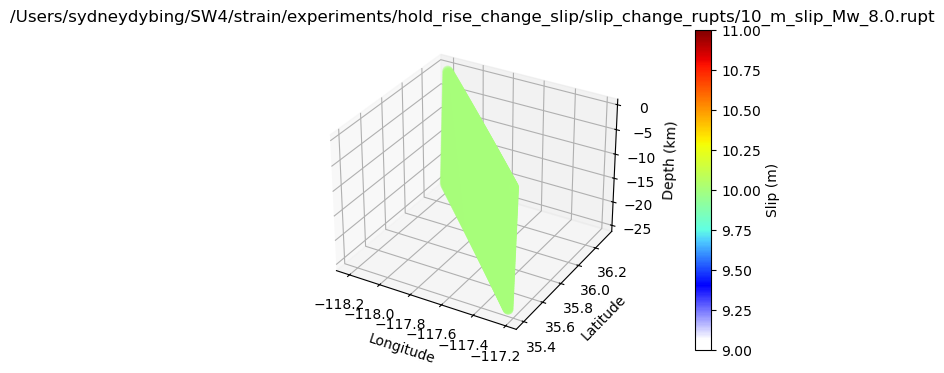

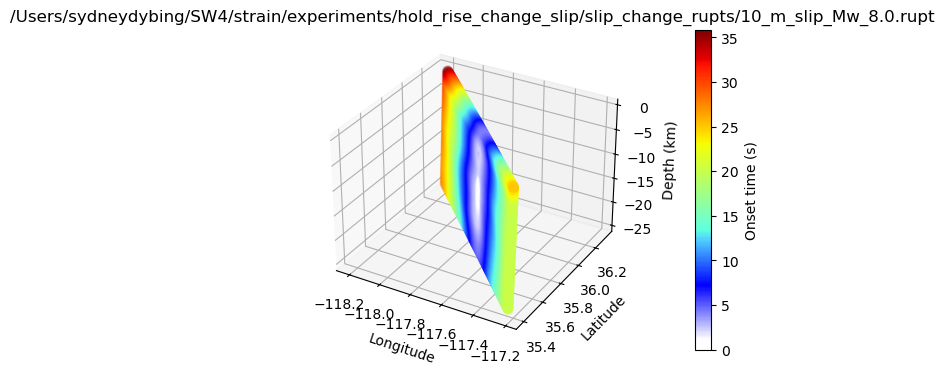

SRF saved!
-------------------------------------------------------------


In [6]:
rupt = rupts_list[1]
new_Mws = []
# rupt
    
for desired_slip in desired_slips:

    # Calculate equivalent homogeneous slip

    slip = np.full(shape = rupture[:,8].shape, fill_value = desired_slip)
    rigidity = rupture[:,13]
    fault_area = rupture[:,10] * rupture[:,11]
    M0_fault_area = np.sum(slip * fault_area * rigidity)
    # equivalent_slip_fault_area = M0_fault_area / (np.sum(fault_area * rigidity)) 
    equivalent_Mw_fault_area = (2/3) * (np.log10(np.sum(fault_area * rigidity * slip)) - 9.1)
    new_Mws.append(round(equivalent_Mw_fault_area,1))
    
    print('Desired slip on each subfault: ' + str(desired_slip) + ' m')
    # print('Fault area: ' + str(np.sum(fault_area)) + ' m^2')
    # print('M0 for fault area: ' + str(M0_fault_area))
    # print('Homogeneous slip at each subfault using fault area: ' + str(round(equivalent_slip_fault_area,3)) + ' m')
    print('Equivalent Mw for homogeneous slip for full fault area: ' + str(round(equivalent_Mw_fault_area,4)))

    print('')

    # Replace heterogeneous slip and rise time with the homogeneous values
    rupture[:,7] = 0 # dura column: rise time - all zero except for the subfaults that slip
    rupture[:,7] = rise_time
    rupture[:,8] = 0
    rupture[:,8] = slip # ss-slip column: Ridgecrest is mostly strike-slip
    rupture[:,9] = 0 # ds-slip column
    
    # New rupture name
    rupt_name = str(desired_slip) + '_m_slip_Mw_' + str(round(equivalent_Mw_fault_area,1))

    # Save new homogeneous .rupt
    out_file = path + 'slip_change_rupts/' + rupt_name + '.rupt'
    formatter = "%d\t%.6f\t%.6f\t%.4f\t%.2f\t%.2f\t%.1f\t%.9e\t%.4e\t%.4e\t%.2f\t%.2f\t%.9e\t%.6e\t%.6f"
    np.savetxt(out_file, rupture, fmt = formatter)

    # # Original rupture
    # view.slip3D(rupt = path + 'hetero_rupts/' + rupt)
    # view.slip3D(rupt = path + 'hetero_rupts/' + rupt, plot_onset = True)

    # Homogeneous rupture
    view.slip3D(rupt = path + 'slip_change_rupts/' + rupt_name + '.rupt')
    view.slip3D(rupt = path + 'slip_change_rupts/' + rupt_name + '.rupt', plot_onset = True)

    # Make the SRF
    rupt_path = path + 'slip_change_rupts/' + rupt_name + '.rupt'
    log_path = path + 'hetero_rupts/logfiles/' + rupt.split('.rupt')[0] + '.log'
    forward.mudpy2srf(rupt_path, log_path)
    print('SRF saved!')

    print('-------------------------------------------------------------')
    


In [7]:
print(desired_slips)
print(new_Mws)

[0.05, 0.1, 0.25, 0.5, 1, 2, 3, 4, 5, 10]
[6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.6, 7.7, 7.8, 8.0]


In [12]:
# Put things in the right folder in the Talapas directory

talapas_dir = '/Users/sydneydybing/SW4/strain/experiments/talapas/to_upload/hold_rise_change_slip/homogeneous/'

for i in range(len(desired_slips)):
    
    desired_slip = desired_slips[i]
    new_Mw = new_Mws[i]

    rupt_dir = talapas_dir + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw)
    # print(rupt_dir)
    
    # Make the folder
    if os.path.isdir(rupt_dir):
        pass
    else:
        os.makedirs(rupt_dir)
        
    # Move the SRFs
    
    srf_path = talapas_dir + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw) + '.srf'
    move(srf_path, rupt_dir)

In [53]:
# Copy the .ins and slurm files to the new folders

het_dir = '/Users/sydneydybing/SW4/strain/experiments/talapas/to_upload/hold_rise_change_slip/heterogeneous/'
slurm_path = het_dir + 'slurm_force_het'
in_path = het_dir + 'force_het.in'

for i in range(len(desired_slips)):
    
    desired_slip = desired_slips[i]
    new_Mw = new_Mws[i]

    rupt_dir = talapas_dir + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw)

    copy(slurm_path, rupt_dir)
    copy(in_path, rupt_dir)

# Modify the .ins and slurm files in each folder

for i in range(len(desired_slips)):
    
    desired_slip = desired_slips[i]
    new_Mw = new_Mws[i]

    rupt_dir = talapas_dir + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw) + '/'
    # print(rupt_dir)
    
    in_path = rupt_dir + 'force_het.in'
    slurm_path = rupt_dir + 'slurm_force_het'
    
    srf_name = str(desired_slip) + '_m_slip_Mw_' + str(new_Mw) + '.srf'
    
    # Open and modify input file
    
    with open(in_path, 'r') as file: 
        data = file.readlines() 
  
    # Edit the .srf path to be the right one 
    data[32] = 'rupture file=' + srf_name + '\n'

    with open(in_path, 'w') as file: 
        file.writelines(data)
        
    move(in_path, rupt_dir + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw) + '.in')
    
    # Open and modify slurm file
    
    with open(slurm_path, 'r') as file: 
        data = file.readlines() 
    
    # Edit the slurm script to match above
    data[1] = '#SBATCH --job-name=sw4_' + str(desired_slip) + 'm_slip     ### Job Name (appears in queue - public)\n'
    data[9] = 'mpirun -np $SLURM_NTASKS sw4 ' + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw) + '.in # Relative path from the SLURM script to the input file in the Talapas file system\n'

    with open(slurm_path, 'w') as file: 
        file.writelines(data)
        
    move(slurm_path, rupt_dir + 'slurm_' + str(desired_slip) + '_m_slip_Mw_' + str(new_Mw))